<a href="https://colab.research.google.com/github/AmiranGozalishvili/Data_Science_course/blob/main/Hotdog_Not_Hotdog_Dataset_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing the libraries
from torchsummary import summary
import pandas as pd
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt
import zipfile
import os
import skimage.io as io

# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score

from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

from google.colab.patches import cv2_imshow
import cv2
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import images

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/datasets/hotdog__not_hotdog.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the folder
zip_ref.close()

In [ ]:
path_test_hot_dog= '/content/hotdog__not_hotdog/test/hot_dog'
path_test_not_hot_dog = '/content/hotdog__not_hotdog/test/not_hot_dog'

path_train_hot_dog = '/content/hotdog__not_hotdog/train/hot_dog'
path_train_not_hot_dog = '/content/hotdog__not_hotdog/train/not_hot_dog'


test_hot_dog = os.listdir(path_test_hot_dog)
test_not_hot_dog = os.listdir(path_test_not_hot_dog)

train_hot_dog = os.listdir(path_train_hot_dog)
train_not_hot_dog = os.listdir(path_train_not_hot_dog)

In [ ]:
test_data = pd.DataFrame()
train_data = pd.DataFrame()

In [ ]:
test = []
test_target = []
test_path = []
for i in range(len(test_not_hot_dog)):
  test.append(test_hot_dog[i])
  test_target.append(1)
  test_path.append(path_test_hot_dog +"/"+ test_hot_dog[i])


  test.append(test_not_hot_dog[i])
  test_target.append(0)
  test_path.append(path_test_not_hot_dog +"/"+ test_not_hot_dog[i])


In [ ]:
train = []
train_target = []
train_path=[]
for j in range(len(train_hot_dog)):
  train.append(train_hot_dog[j])
  train_target.append(1)
  train_path.append(path_train_hot_dog +"/"+ train_hot_dog[j])

  train.append(train_not_hot_dog[j])
  train_target.append(0)
  train_path.append(path_train_not_hot_dog +"/"+ train_not_hot_dog[j])

In [ ]:
test_data['hot_dog'] = test #[0:100]
test_data['target'] = test_target #[0:100]
test_data['path'] = test_path #[0:100]

train_data['hot_dog'] = train #[0:100]
train_data['target'] = train_target #[0:100]
train_data['path'] = train_path #[0:100]

In [ ]:
test_data.path[0]

'/content/hotdog__not_hotdog/test/hot_dog/505584.jpg'

In [ ]:
train_data

,hot_dog,target,path
0,3525466.jpg,1,/content/hotdog__not_hotdog/train/hot_dog/3525...
1,200448.jpg,0,/content/hotdog__not_hotdog/train/not_hot_dog/...
2,1282523.jpg,1,/content/hotdog__not_hotdog/train/hot_dog/1282...
3,134369.jpg,0,/content/hotdog__not_hotdog/train/not_hot_dog/...
4,1322860.jpg,1,/content/hotdog__not_hotdog/train/hot_dog/1322...
...,...,...,...
493,147628.jpg,0,/content/hotdog__not_hotdog/train/not_hot_dog/...
494,1352514.jpg,1,/content/hotdog__not_hotdog/train/hot_dog/1352...
495,217445.jpg,0,/content/hotdog__not_hotdog/train/not_hot_dog/...
496,3764724.jpg,1,/content/hotdog__not_hotdog/train/hot_dog/3764...


# load images and define train and test set

In [ ]:
# loading images
train_img = []
for img_name in tqdm(train_data['path']):
    img = cv2.imread(img_name)
    img = cv2.resize(img, (224,224))
    img = img/255
    train_img.append(img)

train_x = np.array(train_img)
train_y = train_data['target'].values
print(train_x.shape, train_y.shape)

100%|██████████| 498/498 [00:02<00:00, 170.01it/s]


(498, 224, 224, 3) (498,)


In [ ]:
# loading images
test_img = []
for img_name in tqdm(test_data['path']):
    img = cv2.imread(img_name)
    img = cv2.resize(img, (224,224))
    img = img/255
    test_img.append(img)

test_x = np.array(test_img)
test_y = test_data['target'].values
test_x.shape, test_y.shape

100%|██████████| 500/500 [00:01<00:00, 257.13it/s]


((500, 224, 224, 3), (500,))

we can see samples of augmentation.

original image

(512, 512, 3)


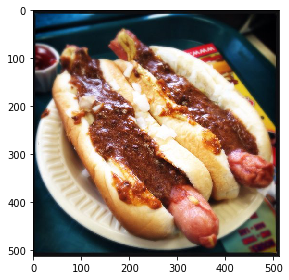

In [ ]:
# reading the image using its path
image = io.imread(train_data['path'][0])
# shape of the image
print(image.shape)
# displaying the image
io.imshow(image)

flip image left-to-right

Text(0.5, 1.0, 'Left to Right Flipped')

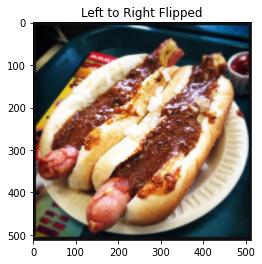

In [ ]:
flipLR = np.fliplr(image)
plt.imshow(flipLR)
plt.title('Left to Right Flipped')

blur the image

Text(0.5, 1.0, 'Blurred Image')

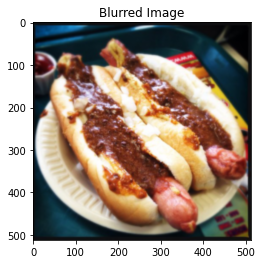

In [ ]:
blurred = gaussian(image,sigma=1,multichannel=True)
plt.imshow(blurred)
plt.title('Blurred Image')

# image augmentation

if we want to enrich our training set, we can use some augmentation methods.

(rotation, flip, add noise, blurry)

with help of augmentation we can generate new images using the existing

training images and hence we don’t have to collect them manually.


In [ ]:
final_train_data = []
final_target_train = []
for i in tqdm(range(train_x.shape[0])):
    final_train_data.append(train_x[i])

    # generade images with rotation and random noise methods
    final_train_data.append(rotate(train_x[i], angle=45, mode = 'wrap'))
    final_train_data.append(random_noise(train_x[i],var=0.2**2))

    for j in range(3):
        final_target_train.append(train_y[i])

100%|██████████| 498/498 [00:04<00:00, 100.45it/s]


In [ ]:
print(len(final_target_train), len(final_train_data))
final_train = np.array(final_train_data)
final_target_train = np.array(final_target_train)

1494 1494


plot contains original, rotated and random_noise added images

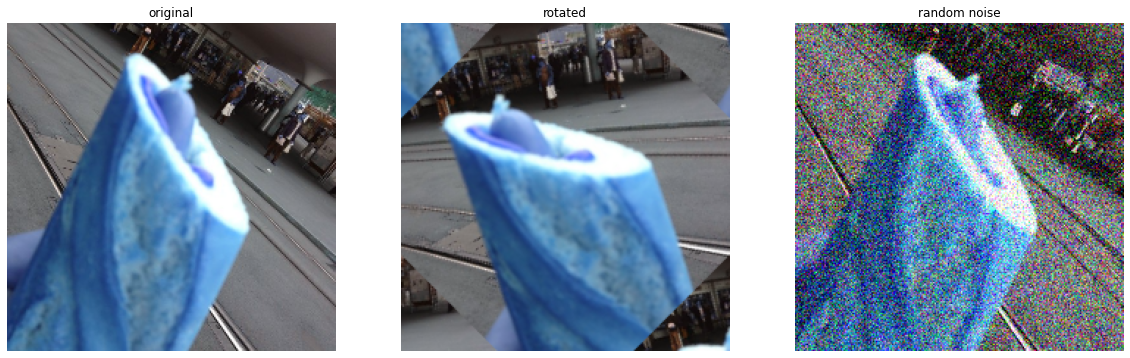

In [ ]:
names=['original', 'rotated', 'random noise']
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,20))
for i in range(3):
    ax[i].imshow(final_train[i+30])
    ax[i].set_title(names[i])
    ax[i].axis('off')

# converting training, testing images and target into torch tensors

In [ ]:
# converting training images into torch tensor
final_train = final_train.reshape(len(final_target_train), 3, 224, 224)
final_train  = torch.from_numpy(final_train)
final_train = final_train.float()

# converting the target into torch tensor
final_target_train = final_target_train.astype(int)
final_target_train = torch.from_numpy(final_target_train)

In [ ]:
# converting test images into torch tensor
test_x = test_x.reshape(len(test_y), 3, 224, 224)
test_x  = torch.from_numpy(test_x)
test_x = test_x.float()

# converting the target into torch tensor
test_y = test_y.astype(int)
test_y = torch.from_numpy(test_y)

# neuran network model

In [ ]:
torch.manual_seed(0)

class Net(Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
        )

        self.linear_layers = Sequential(
            Linear(128 * 14 * 14, 512),
            ReLU(inplace=True),
            Dropout(),
            Linear(512, 256),
            ReLU(inplace=True),
            Dropout(),
            Linear(256,10),
            ReLU(inplace=True),
            Dropout(),
            Linear(10,2)
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.00005)
# defining the loss function
criterion = CrossEntropyLoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Con

# Training model

In [ ]:
torch.manual_seed(0)

# batch size of the model
batch_size = 32

# number of epochs to train the model
n_epochs = 100

training_loss = []
# pred = []

for epoch in range(1, n_epochs+1):

    train_loss = 0.0

    permutation = torch.randperm(final_train.size()[0])

    # training_loss = []
    for i in tqdm(range(0,final_train.size()[0], batch_size)):
        # print(i)
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = final_train[indices], final_target_train[indices]

        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        # print(batch_x, batch_y)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)
        # pred.append(outputs)

        # training_loss.append(loss.item())

        loss.backward()
        optimizer.step()

        training_loss.append(loss.item())

# training_loss = np.average(training_loss)
print('epoch: \t', epoch, '\t training loss: \t', np.average(training_loss))

100%|██████████| 47/47 [00:03<00:00, 12.13it/s]

epoch: 	 100 	 training loss: 	 0.261117067233798


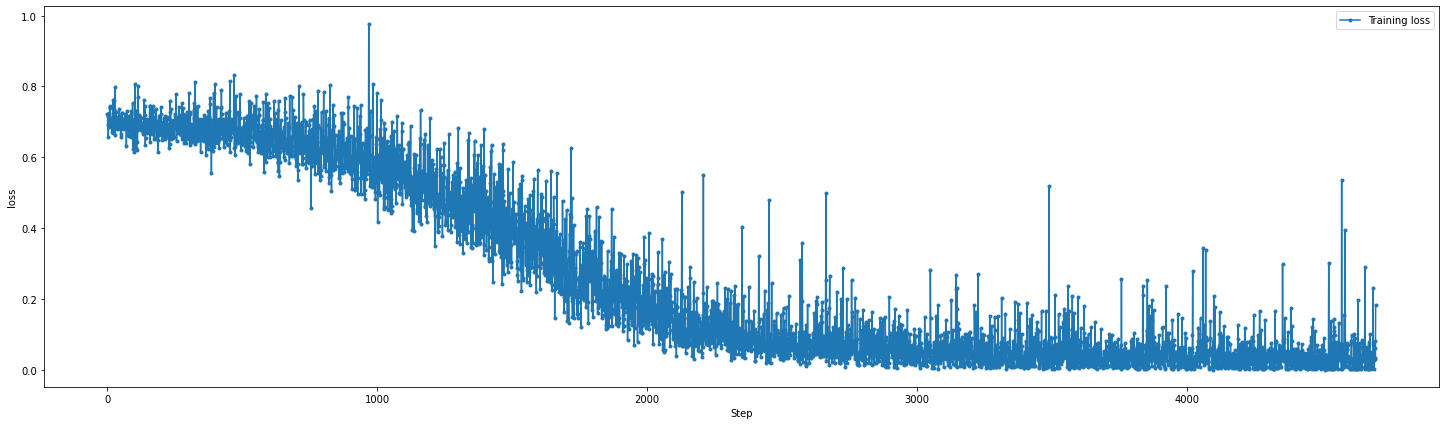

In [ ]:
plt.rcParams["figure.figsize"] = (25, 7)
plt.plot(np.arange(0, len(training_loss)), training_loss, marker='.', label="Training loss")
# plt.plot(np.arange(0, len(pred)), pred, 'r', label="Prediction")
plt.ylabel('loss')
plt.xlabel('Step')
plt.legend()
plt.show();

# prediction metrics

In [ ]:
torch.manual_seed(0)
# prediction for training set

prediction = []
target = []

permutation = torch.randperm(final_train.size()[0])
for i in tqdm(range(0,final_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = final_train[indices], final_target_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output= model(batch_x)

    predictions = torch.exp(output).cpu().numpy().argmax(axis=1).tolist()
    prediction.append(predictions)
    target.append(batch_y)

# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))

print('training accuracy: \t', np.average(accuracy))

100%|██████████| 47/47 [00:01<00:00, 31.14it/s]

training accuracy: 	 0.9830754352030947


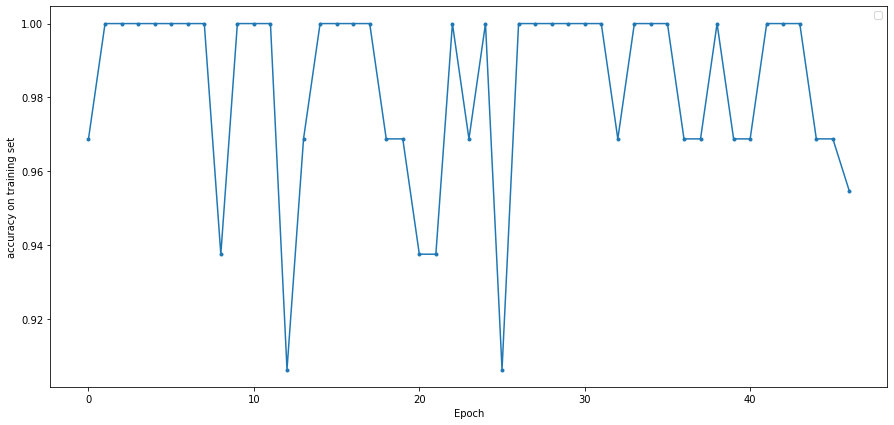

In [ ]:
plt.rcParams["figure.figsize"] = (15, 7)
plt.plot(np.arange(0, len(accuracy)), accuracy, marker='.')
plt.ylabel('accuracy on training set')
plt.xlabel('Epoch')
plt.legend()
plt.show();

predict performance on test set

i used only part of testing images, because it crashes while use all samples

In [ ]:
# checking the performance on test set
torch.manual_seed(0)

output= model(test_x[0:200].cuda())

predictions = torch.exp(output).cpu().detach().numpy().argmax(axis=1).tolist()

accuracy_score(test_y[0:200], predictions)

0.61

In [ ]:
y_test = test_y[0:200]
pred = predictions

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.61      0.60      0.61       100
           1       0.61      0.62      0.61       100

    accuracy                           0.61       200
   macro avg       0.61      0.61      0.61       200
weighted avg       0.61      0.61      0.61       200



# PyTorch pretrained models

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116


In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/content/hotdog__not_hotdog"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and testidation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and testidation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [ ]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 498
     Root location: /content/hotdog__not_hotdog/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'test': Dataset ImageFolder
     Number of datapoints: 500
     Root location: /content/hotdog__not_hotdog/test
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


initialize model **squeezenet**

In [ ]:
initialize_model(model_name='squeezenet', num_classes=num_classes, feature_extract=True, use_pretrained=True)

(SqueezeNet(
   (features): Sequential(
     (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
     (1): ReLU(inplace=True)
     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
     (3): Fire(
       (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
       (squeeze_activation): ReLU(inplace=True)
       (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
       (expand1x1_activation): ReLU(inplace=True)
       (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (expand3x3_activation): ReLU(inplace=True)
     )
     (4): Fire(
       (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
       (squeeze_activation): ReLU(inplace=True)
       (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
       (expand1x1_activation): ReLU(inplace=True)
       (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (expand3x3_activation): ReLU(inplace=True)
    

we can see initialized pretrained model squeezenet performance

when parameter: .requires_grad=False, pretrained model weights doesn't updating.

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.7748 Acc: 0.5542
test Loss: 0.6485 Acc: 0.6780

Epoch 1/14
----------
train Loss: 0.6129 Acc: 0.6687
test Loss: 0.5615 Acc: 0.7400

Epoch 2/14
----------
train Loss: 0.5361 Acc: 0.7349
test Loss: 0.5089 Acc: 0.7900

Epoch 3/14
----------
train Loss: 0.4989 Acc: 0.7691
test Loss: 0.4775 Acc: 0.7880

Epoch 4/14
----------
train Loss: 0.4417 Acc: 0.7932
test Loss: 0.4446 Acc: 0.8060

Epoch 5/14
----------
train Loss: 0.4303 Acc: 0.8052
test Loss: 0.4184 Acc: 0.8200

Epoch 6/14
----------
train Loss: 0.4597 Acc: 0.7671
test Loss: 0.4065 Acc: 0.8260

Epoch 7/14
----------
train Loss: 0.4203 Acc: 0.8273
test Loss: 0.3978 Acc: 0.8360

Epoch 8/14
----------
train Loss: 0.4177 Acc: 0.8474
test Loss: 0.3861 Acc: 0.8360

Epoch 9/14
----------
train Loss: 0.3910 Acc: 0.8373
test Loss: 0.3758 Acc: 0.8320

Epoch 10/14
----------
train Loss: 0.3898 Acc: 0.8193
test Loss: 0.3677 Acc: 0.8460

Epoch 11/14
----------
train Loss: 0.3738 Acc: 0.8353
test Loss: 0.3691 Acc

here we can compare performances of pretrained freezed sqeezenet and unfreezed model.

Epoch 0/14
----------
train Loss: 0.7065 Acc: 0.4799
test Loss: 0.6931 Acc: 0.5000

Epoch 1/14
----------
train Loss: 0.6931 Acc: 0.4940
test Loss: 0.6931 Acc: 0.5000

Epoch 2/14
----------
train Loss: 0.6931 Acc: 0.5000
test Loss: 0.6931 Acc: 0.5000

Epoch 3/14
----------
train Loss: 0.6932 Acc: 0.4960
test Loss: 0.6931 Acc: 0.5000

Epoch 4/14
----------
train Loss: 0.6931 Acc: 0.5040
test Loss: 0.6931 Acc: 0.5000

Epoch 5/14
----------
train Loss: 0.6931 Acc: 0.5020
test Loss: 0.6931 Acc: 0.5000

Epoch 6/14
----------
train Loss: 0.6931 Acc: 0.4980
test Loss: 0.6931 Acc: 0.5000

Epoch 7/14
----------
train Loss: 0.6931 Acc: 0.5040
test Loss: 0.6931 Acc: 0.5000

Epoch 8/14
----------
train Loss: 0.6931 Acc: 0.4980
test Loss: 0.6931 Acc: 0.5000

Epoch 9/14
----------
train Loss: 0.6931 Acc: 0.4900
test Loss: 0.6931 Acc: 0.5000

Epoch 10/14
----------
train Loss: 0.6931 Acc: 0.5020
test Loss: 0.6931 Acc: 0.5000

Epoch 11/14
----------
train Loss: 0.6932 Acc: 0.4859
test Loss: 0.6931 Acc

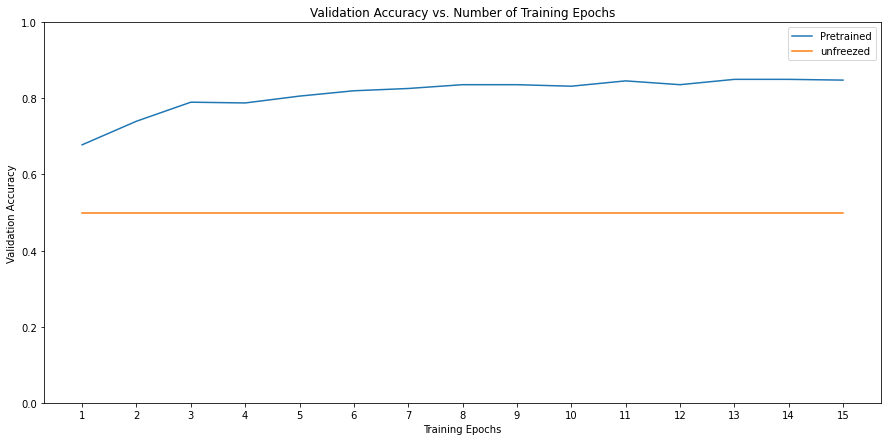

In [ ]:
# Initialize the non-pretrained version of the model used for this run
unfreezed_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)
unfreezed_model = unfreezed_model.to(device)
unfreezed_optimizer = optim.SGD(unfreezed_model.parameters(), lr=0.001, momentum=0.9)
unfreezed_criterion = nn.CrossEntropyLoss()
_,unfreezed_hist = train_model(unfreezed_model, dataloaders_dict, unfreezed_criterion, unfreezed_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from unfreezed
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in unfreezed_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="unfreezed")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

initialize model **rsnet**

In [ ]:
initialize_model(model_name='resnet', num_classes=num_classes, feature_extract=True, use_pretrained=True)
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/14
----------
train Loss: 0.3814 Acc: 0.8414
test Loss: 0.3707 Acc: 0.8400

Epoch 1/14
----------
train Loss: 0.3442 Acc: 0.8454
test Loss: 0.3551 Acc: 0.8480

Epoch 2/14
----------
train Loss: 0.3672 Acc: 0.8253
test Loss: 0.3511 Acc: 0.8440

Epoch 3/14
----------
train Loss: 0.3396 Acc: 0.8514
test Loss: 0.3560 Acc: 0.8600

Epoch 4/14
----------
train Loss: 0.3426 Acc: 0.8594
test Loss: 0.3617 Acc: 0.8540

Epoch 5/14
----------
train Loss: 0.3539 Acc: 0.8454
test Loss: 0.3610 Acc: 0.8500

Epoch 6/14
----------
train Loss: 0.3114 Acc: 0.8594
test Loss: 0.3705 Acc: 0.8420

Epoch 7/14
----------
train Loss: 0.3283 Acc: 0.8735
test Loss: 0.3360 Acc: 0.8580

Epoch 8/14
----------
train Loss: 0.2968 Acc: 0.8855
test Loss: 0.3419 Acc: 0.8560

Epoch 9/14
----------
train Loss: 0.3191 Acc: 0.8735
test Loss: 0.3409 Acc: 0.8640

Epoch 10/14
----------
train Loss: 0.3154 Acc: 0.8755
test Loss: 0.3424 Acc: 0.8600

Epoch 11/14
----------
train Loss: 0.3494 Acc: 0.8514
test Loss: 0.3450 Acc

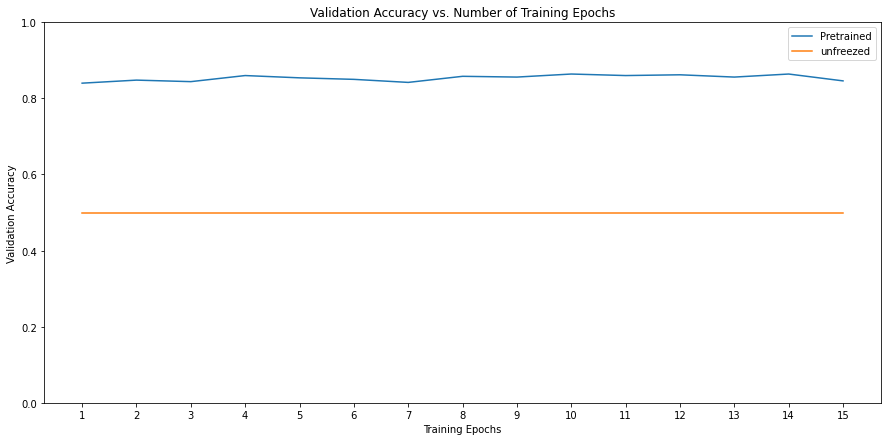

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from unfreezed
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in unfreezed_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="unfreezed")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

as we can see pretrained freeze models has better performance than unfreezed

and also resnet model has slightly better performance than
squeezenet